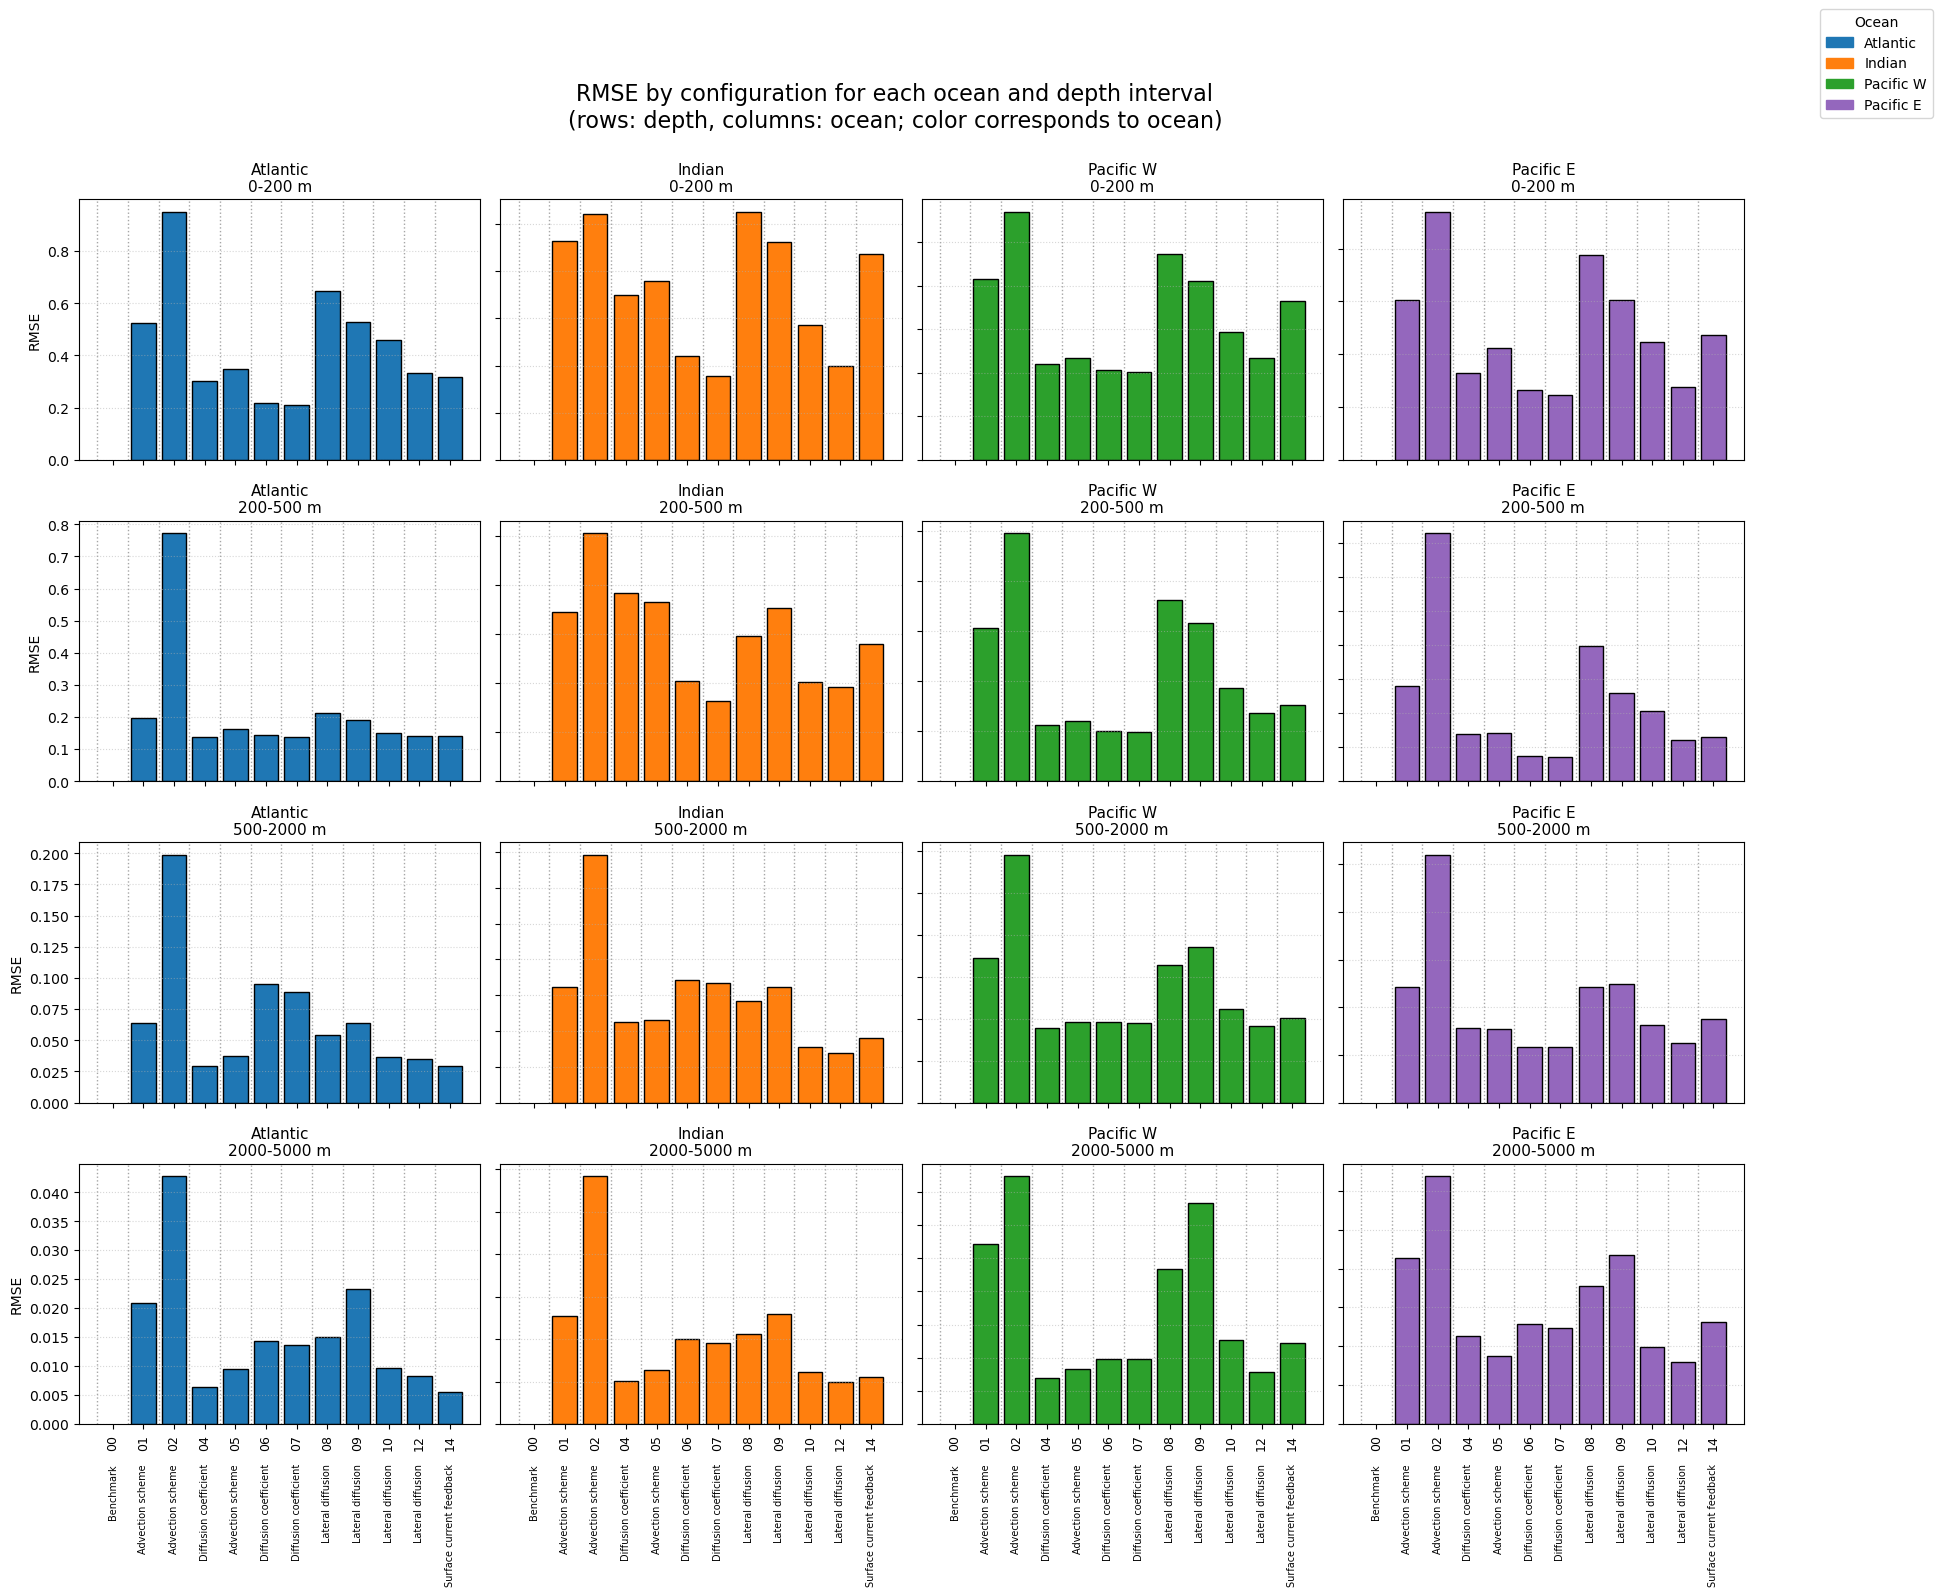

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- Global variable: desired depth intervals to plot (min_depth, max_depth) ---
DESIRED_HEIGHTS = [
    (0, 200),      # "upper"
    (200, 500),    # "middle"
    (500, 2000),   # "deep"
    (2000, 5000),  # "very deep"
]

# --- Setup ---
DATA_DIR = os.path.expanduser("~/NEMOCheck/data/model")
ref = xr.open_dataset(os.path.join(DATA_DIR, "nemo00_1m_201001_202212_Eq.nc")).sel(time_counter=slice("2011-01-01", "2022-12-31"))
ref = ref["to"]

# Ocean domains (lon_min, lon_max) for each ocean
OCEAN_DOMAINS = {
    "Atlantic":  (-60, 20),
    "Indian":    (30, 110),
    "Pacific W": (120, 180),
    "Pacific E": (-180, -70),
}
ocean_names = list(OCEAN_DOMAINS.keys())
ocean_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"]
ocean_color_dict = dict(zip(ocean_names, ocean_colors))

cfgs = ["00", "01", "02", "04", "05", "06", "07", "08", "09", "10", "12", "14"]

cfg_descriptions = [
    "Benchmark",                           # 00
    "Advection scheme",                    # 01
    "Advection scheme",                    # 02
    #"Surface current feedback",            # 03
    "Diffusion coefficient",               # 04
    "Advection scheme",                    # 05
    "Diffusion coefficient",               # 06
    "Diffusion coefficient",               # 07
    "Lateral diffusion",                   # 08
    "Lateral diffusion",                   # 09
    "Lateral diffusion",                   # 10
    "Lateral diffusion",                   # 12
    "Surface current feedback"             # 14
]

lon = ref["nav_lon_grid_T"]
depth = ref["deptht"]

# Build all (ocean, depth_range) "boxes"
BOXES = []
for min_depth, max_depth in DESIRED_HEIGHTS:
    for ocean in ocean_names:
        lon_min, lon_max = OCEAN_DOMAINS[ocean]
        box_label = f"{ocean} {min_depth}-{max_depth}m"
        BOXES.append( (box_label, ocean, min_depth, max_depth, lon_min, lon_max) )

mean_errors = np.full((len(cfgs), len(BOXES)), np.nan)

for i, cfg in enumerate(cfgs):
    if cfg == "00":
        continue
    ds = xr.open_dataset(os.path.join(DATA_DIR, f"nemo{cfg}_1m_201001_202212_Eq.nc"))
    ds = ds.sel(time_counter=slice("2011-01-01", "2022-12-31"))
    ds = ds["to"]
    error = ref - ds

    for j, (box_label, ocean, min_depth, max_depth, lon_min, lon_max) in enumerate(BOXES):
        lon_mask = (lon >= lon_min) & (lon <= lon_max)
        depth_mask = (depth >= min_depth) & (depth < max_depth)
        masked = error.where(lon_mask)
        masked = masked.sel(deptht=depth[depth_mask])
        rmse = np.sqrt((masked ** 2).mean(skipna=True)).item()
        mean_errors[i, j] = rmse
    ds.close()

# --- Plot: One panel per desired depth interval ---
n_cfg = len(cfgs)
n_boxes = len(BOXES)
n_rows = len(DESIRED_HEIGHTS)
n_cols = len(ocean_names)

fig, axes = plt.subplots(
    nrows=n_rows, ncols=n_cols, figsize=(4.5 * n_cols, 4 * n_rows),
    sharex=True, sharey=False  # <-- DO NOT share y, so each depth (row) has independent y-axis
)

if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1 or n_cols == 1:
    axes = axes.reshape((n_rows, n_cols))

for row, (min_depth, max_depth) in enumerate(DESIRED_HEIGHTS):
    for col, ocean in enumerate(ocean_names):
        ax = axes[row, col]
        # Find the box index for this ocean and depth
        box_idx = [i for i, box in enumerate(BOXES)
                   if box[1] == ocean and box[2] == min_depth and box[3] == max_depth][0]
        heights_to_plot = mean_errors[:, box_idx]
        ax.bar(np.arange(n_cfg), heights_to_plot, color=ocean_color_dict[ocean], edgecolor="black")
        ax.set_title(f"{ocean}\n{min_depth}-{max_depth} m", fontsize=11)
        for xi in np.arange(n_cfg):
            ax.axvline(x=xi-0.5, color='grey', linestyle=':', linewidth=1, alpha=0.7, zorder=0)
        ax.grid(axis='y', linestyle=':', alpha=0.5)
        if row == n_rows - 1:
            ax.set_xticks(np.arange(n_cfg))
            ax.set_xticklabels(cfgs, fontsize=9, rotation=90)
            for j, desc in enumerate(cfg_descriptions):
                ax.text(j, ax.get_ylim()[0] - 0.15 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
                        desc, rotation=90, fontsize=7, va='top', ha='center')
        else:
            ax.set_xticks([])
        if col == 0:
            ax.set_ylabel("RMSE")
        else:
            ax.set_yticklabels([])

handles = [Patch(color=ocean_color_dict[o], label=o) for o in ocean_names]
fig.legend(handles=handles, title="Ocean", bbox_to_anchor=(1.01, 1), loc='upper left')

fig.suptitle(
    "RMSE by configuration for each ocean and depth interval\n"
    "(rows: depth, columns: ocean; color corresponds to ocean)",
    y=0.95, fontsize=16
)
plt.tight_layout(rect=[0,0,0.98,0.95])
plt.savefig("depth.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

# Notes

- surface current feedback wasn't the highest error differnce with obs horizontally
- different surface current feedback behaves very differently
- 03 changes even in the deep ocean but more with the Atlantic
- quite a difference in the pacifics
- lateral diffusion, Pacific W, 200-500m